In [1]:
%pylab inline
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from itertools import cycle, islice
from scipy.io import loadmat
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

from sklearn.manifold import MDS
from sklearn.cluster import SpectralClustering
from numpy import linalg as LA
from scipy.linalg import eigh

from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
from scipy.io import loadmat

from sklearn.manifold import MDS
from sklearn.cluster import SpectralClustering

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors

Populating the interactive namespace from numpy and matplotlib
Automatically created module for IPython interactive environment


In [2]:
def pca_spec(X, radius=0.2, d=1, n_clusters=2, eta=1.05, eps=0.05):
    nbrs = NearestNeighbors(radius=radius, algorithm='ball_tree').fit(X)
    distances, X_neighbors = nbrs.radius_neighbors(X)
    point_indices_master = pd.Series(range(X.shape[0]))
    

    # Step 0. Pick point y1 from data. pick y2 from data not in the neighborhood of y1. Pick y3 not in neighborhood of y1 and y2
    # Keep doing till n0 centers are found
    y_n0_centers = []
    while len(point_indices_master)>0:
        y = np.random.choice(point_indices_master, 1)[0]
        y_n0_centers.append(y)
        
        # Generate neighbors
        y_neighbors = X_neighbors[y]
        y_neighbors = y_neighbors[y_neighbors!=y]
        # Drop picked center from being picked up ever later
        point_indices_master.drop(y, inplace=True)
        # Drop picked center's neighbors
        point_indices_master.drop(y_neighbors, inplace=True, errors='ignore')
    # Step 1 for each i=1..mo0, calculate the sample covariance matrix C1 of neirhborhood of yi
    covariances = []
    center_means = []
    print('N: {}'.format(len(y_n0_centers)))

    for center in y_n0_centers:
        neighbor_matrix = X[X_neighbors[center]]
        center_mean = neighbor_matrix.mean(axis=0)
        center_means.append(center_mean)
        Y = np.matlib.repmat(center_mean, neighbor_matrix.shape[0], 1)
        cov  = np.dot(Y.T, Y)/(Y.shape[0]-1)        
        covariances.append(cov)
    
    Q = []
    for cov in covariances:
        
        U, s, V = LA.svd(cov)
        Q.append(np.dot(U[:, :d], U[:, :d].T))
    
    A = np.zeros((len(y_n0_centers), len(y_n0_centers)))
    B = np.zeros((len(y_n0_centers), len(y_n0_centers)))
    for i in range(len(y_n0_centers)):
        for j in range(len(y_n0_centers)):
            A[i, j] = LA.norm(center_means[i]-center_means[j], 2)
            B[i, j] = LA.norm(Q[i]-Q[j], 2)
    
    connected_A = np.max(np.min(A+100*np.eye(A.shape[0]), axis=0))
    connected_graph = A<connected_A
    connected_graph = connected_graph.astype(int)
    
    connected_graph = connected_graph - np.diag(np.diag(connected_graph))
    if np.sum(connected_graph) > 0:
        is_center_connectected = np.dot(B, connected_graph).flatten()        
        eta = np.nanmedian(is_center_connectected)/10
    
    eps = connected_A
    W = np.multiply(np.exp(-np.power(A, 2)/eps**2), np.exp(-np.power(B, 2)/eta**2))
    clustering = SpectralClustering(n_clusters=n_clusters,
                                    assign_labels="kmeans",
                                    affinity='precomputed',
                                    random_state=0).fit(W)


    centers = X[y_n0_centers]

    distances = euclidean_distances(X, centers)
    min_distance_centers = np.argmin(distances, axis=1)
    color_indices = pd.Series(clustering.labels_)[min_distance_centers]
    colors = pd.Series(sns.color_palette('Paired'))    
    return color_indices#, clustering.labels_

N: 118
N: 69
N: 34
N: 13
N: 4
N: 172
N: 65
N: 37


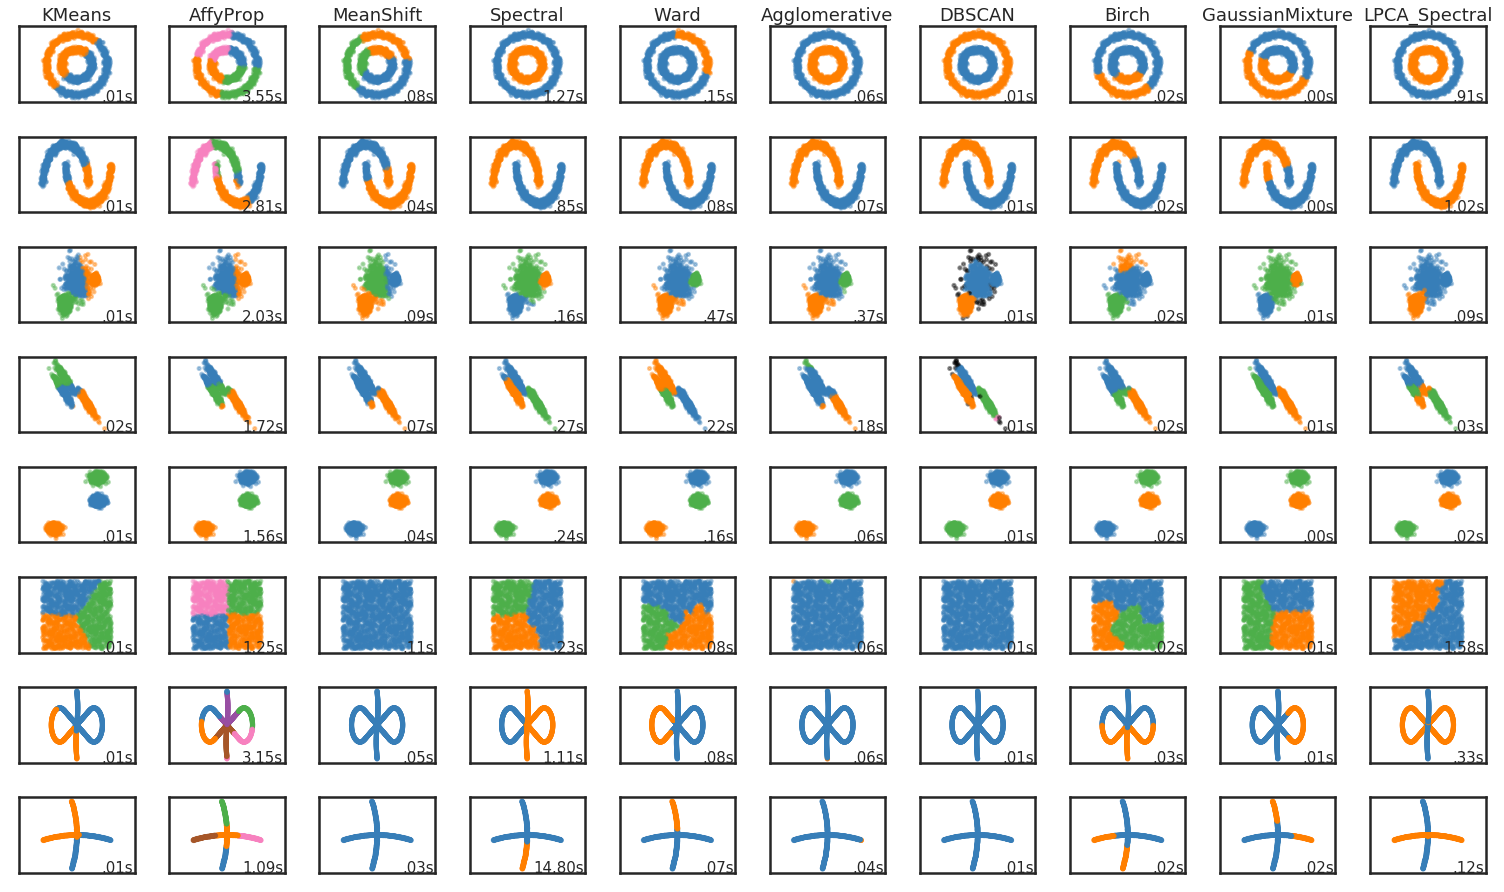

In [19]:
from sklearn import cluster, datasets, mixture

np.random.seed(42)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None
data = loadmat('../local-pca-code-matlab/self_intersecting.mat')
self_intersecting = data['X'], data['Y']

data = loadmat('../local-pca-code-matlab/twocurves0.mat')
twocurves1  = data['Y'], data['Y']

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
fig = plt.figure(figsize=(9 * 2 + 3, 12.5))
fig.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {}),
    (self_intersecting, {'n_clusters': 2}),
    (twocurves1, {'n_clusters': 2})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('KMeans', two_means),
        ('AffyProp', affinity_propagation),
        ('MeanShift', ms),
        ('Spectral', spectral),
        ('Ward', ward),
        ('Agglomerative', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm),
        ('LPCA_Spectral', pca_spec),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            if name != 'LPCA_Spectral':
                
                algorithm.fit(X)
            else:
                if i_dataset == 2:
                    pca_spec_results = pca_spec(X, radius=0.5)
                elif i_dataset == 3:
                    pca_spec_results = pca_spec(X, radius=0.7, d=1, n_clusters=3)
                elif i_dataset == 4:
                    pca_spec_results = pca_spec(X, radius=0.7, n_clusters=3)
                elif i_dataset == 7:
                    pca_spec_results = pca_spec(X, radius=0.2, n_clusters=2)
                else:
                    pca_spec_results = pca_spec(X)

        t1 = time.time()
        if name == 'LPCA_Spectral':
            y_pred = pca_spec_results.astype(np.int)
        elif hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        ax = plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred], alpha=0.4)

        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-2.5, 2.5)
        ax.axis('equal')
        ax.xticks(())
        ax.yticks(())
        ax.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
fig.tight_layout()
fig.savefig('all_clustering_algo.pdf')

In [5]:
 pca_spec_results = pca_spec(X, radius=0.2, n_clusters=2)

N: 38
